In [ ]:
#Try with KOME_BERT s

In [1]:
pip install transformers torch pandas --upgrade

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/ad/ff/b3e311e58b9c90b149fb957953b228287d7c9fe78df9a3a72e8715c5fc56/transformers-4.43.3-py3-none-any.whl.metadata
  Using cached transformers-4.43.3-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.43.3-py3-none-any.whl (9.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

/Users/jaehyoyi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Load your dataset
df = pd.read_csv("/Users/jaehyoyi/Desktop/인화원/MORAL_EMOTION/Moral-Emotion/data/train.csv")

# Assume the text column is named 'text'
#texts = df['text'].tolist()

In [20]:
!pip uninstall transformers -y
!pip install transformers -y

Found existing installation: transformers 4.43.3
Uninstalling transformers-4.43.3:
  Successfully uninstalled transformers-4.43.3

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


In [4]:
#Code for predicted label

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load dataset
file_path = "/Users/jaehyoyi/Desktop/인화원/MORAL_EMOTION/Moral-Emotion/data/train.csv"
df = pd.read_csv(file_path)

# Select the first 500 rows
df = df.head(500)

# Load pre-trained model and tokenizer
model_name = "Chaeyoon/BERT-Moral-Emotion-KOR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Preprocess the data
def preprocess_function(text):
    return tokenizer(text, return_tensors='pt', padding=True, truncation=True)

df['inputs'] = df['tokens'].apply(lambda x: preprocess_function(str(x)))

# Make predictions
def predict(inputs):
    inputs = {k: v.to(torch.device('cpu')) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
    return predictions.cpu().numpy()

df['predictions'] = df['inputs'].apply(lambda x: predict(x))

# Save the predictions
df.to_csv('predictions.csv', index=False)


KeyboardInterrupt: 

In [5]:
#Code for Probability for MORAL emotion
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# Load dataset
file_path = "/Users/jaehyoyi/Desktop/인화원/MORAL_EMOTION/Moral-Emotion/data/train.csv"
df = pd.read_csv(file_path)

# Select the first 1000 rows
df = df.head(1000)

# Load pre-trained model and tokenizer
model_name = "Chaeyoon/BERT-Moral-Emotion-KOR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Preprocess the data
def preprocess_function(text):
    return tokenizer(text, return_tensors='pt', padding=True, truncation=True)

df['inputs'] = df['tokens'].apply(lambda x: preprocess_function(str(x)))

# Make predictions and get probabilities
def predict(inputs):
    inputs = {k: v.to(torch.device('cpu')) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1).cpu().numpy()
    return probabilities

df['predictions'] = df['inputs'].apply(lambda x: predict(x).squeeze(0))

# Create a DataFrame with probabilities
probabilities_df = pd.DataFrame(df['predictions'].tolist(), columns=[
    'Non-Moral-Emotion', 'Neutral', 'Other-Suffering', 'Other-Praising', 'Other-Condemning', 'Self-Conscious'])

# Add the original text column to the output DataFrame
probabilities_df['tokens'] = df['tokens'].values

# Save the probabilities to a CSV file
probabilities_df.to_csv('predictions_probabilities.csv', index=False)

# Display the first few rows of the output DataFrame
probabilities_df.head()


,Non-Moral-Emotion,Neutral,Other-Suffering,Other-Praising,Other-Condemning,Self-Conscious,tokens
0,0.000579,0.000106,0.000297,0.000161,0.000192,0.998664,@user 왱 ? ? 원래 모든 아빠는 딸의 것 아님 ? ?
1,0.998722,0.000198,0.000258,0.000422,0.000329,0.000071,@user 아덴트님도 해피 병신ㄴ ... !
2,0.000048,0.000046,0.000062,0.000063,0.000110,0.999671,썰렁
3,0.999597,0.000077,0.000073,0.000073,0.000116,0.000064,진짜 겁나 막장이야ㅋㅋㅋ학생도 선생도 다ㅋㅋㅋ떠들어놓고 내가 뭘했냐면서 지랄하는 학...
4,0.000343,0.000461,0.000274,0.000227,0.998569,0.000127,@user @user 마르언니가 졸리다뇨 ? 악몽의 환영 스킬이 모니터를 뚫는거신가...


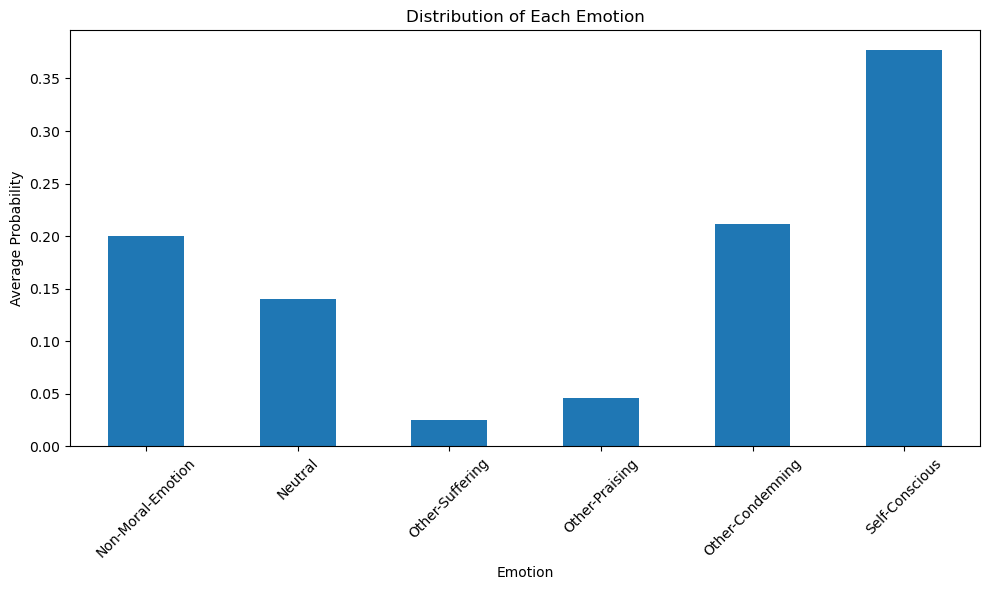

In [6]:
#code for historgram of the distribution of the emotions
import pandas as pd
import matplotlib.pyplot as plt

# Load the probabilities CSV file
file_path = '/Users/jaehyoyi/Desktop/인화원/MORAL_EMOTION/Moral-Emotion/predictions_probabilities.csv'  # Update this path to your local file
probabilities_df = pd.read_csv(file_path)

# Calculate the mean probabilities for each emotion to get the distribution
mean_probabilities = probabilities_df[['Non-Moral-Emotion', 'Neutral', 'Other-Suffering', 'Other-Praising', 'Other-Condemning', 'Self-Conscious']].mean()

# Plot the distribution of each emotion
plt.figure(figsize=(10, 6))
mean_probabilities.plot(kind='bar')
plt.title('Distribution of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Probability')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image
plot_path = 'emotion_distribution.png'  # Update this path if needed
plt.savefig(plot_path)

# Display the plot
plt.show()

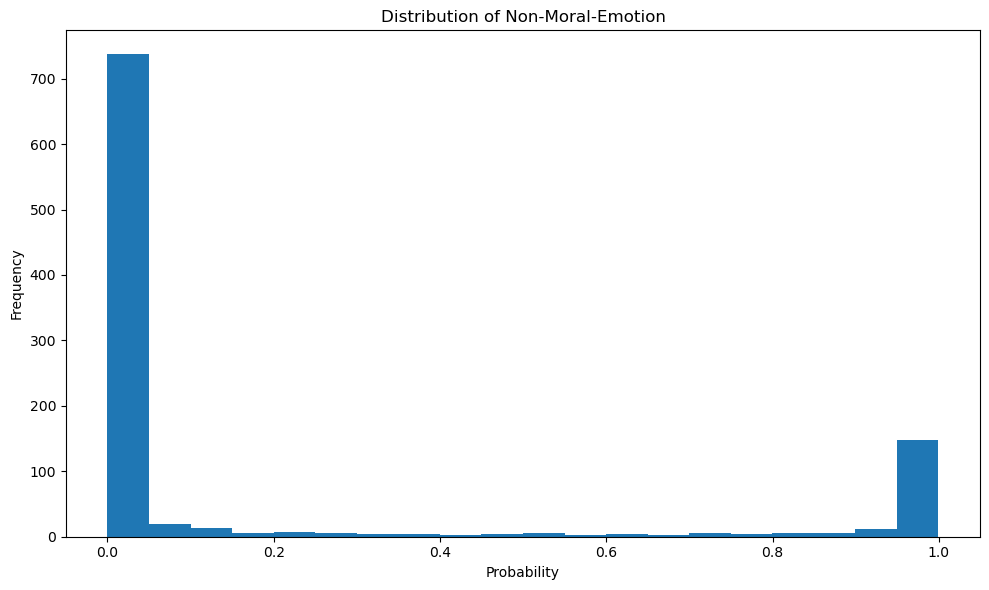

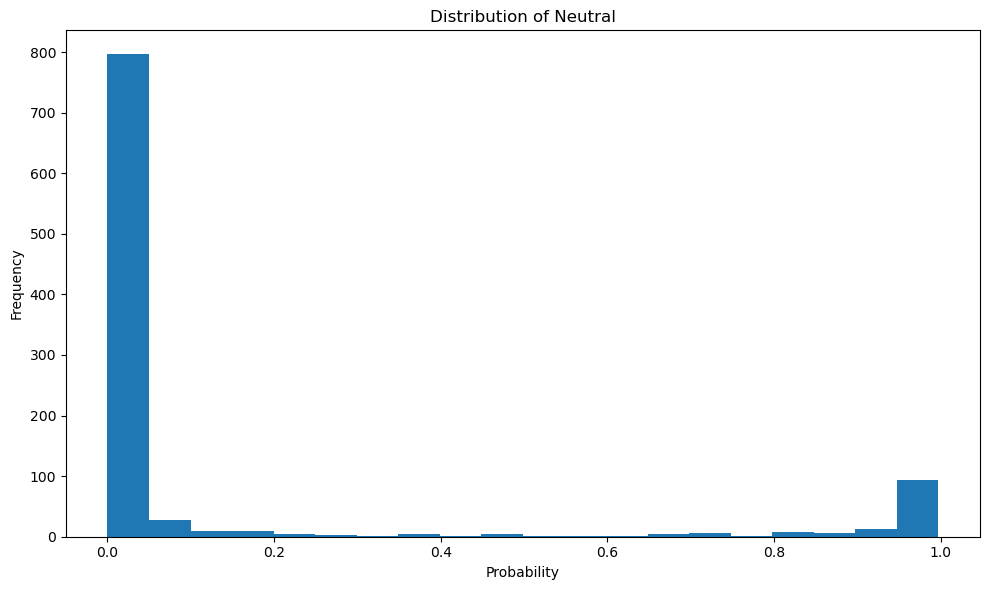

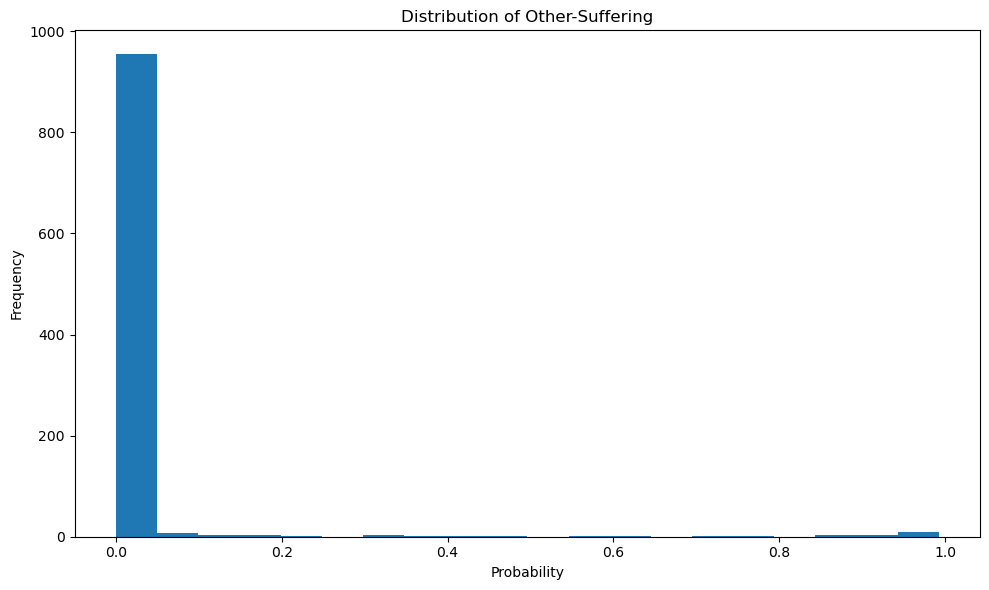

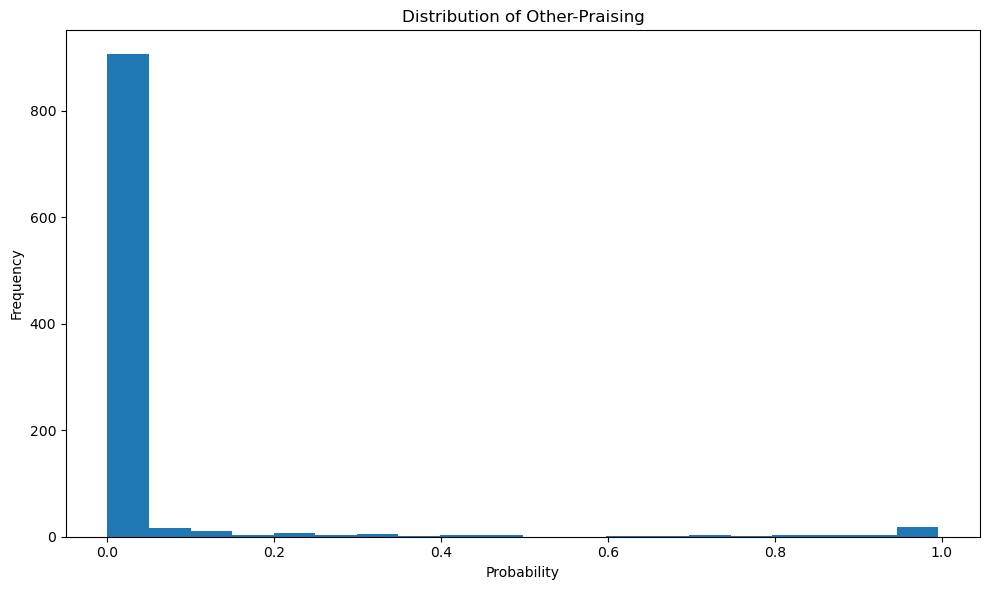

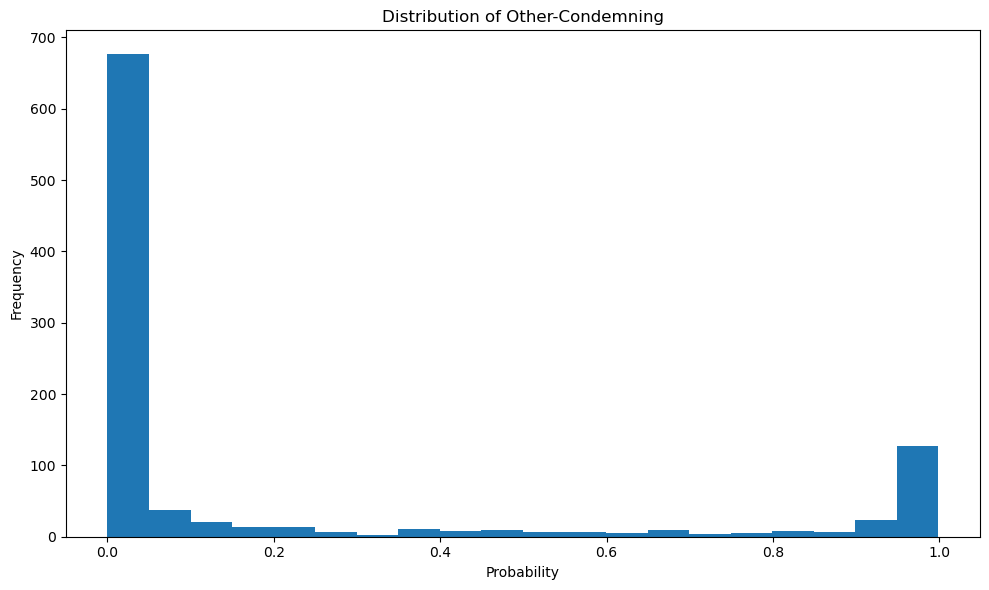

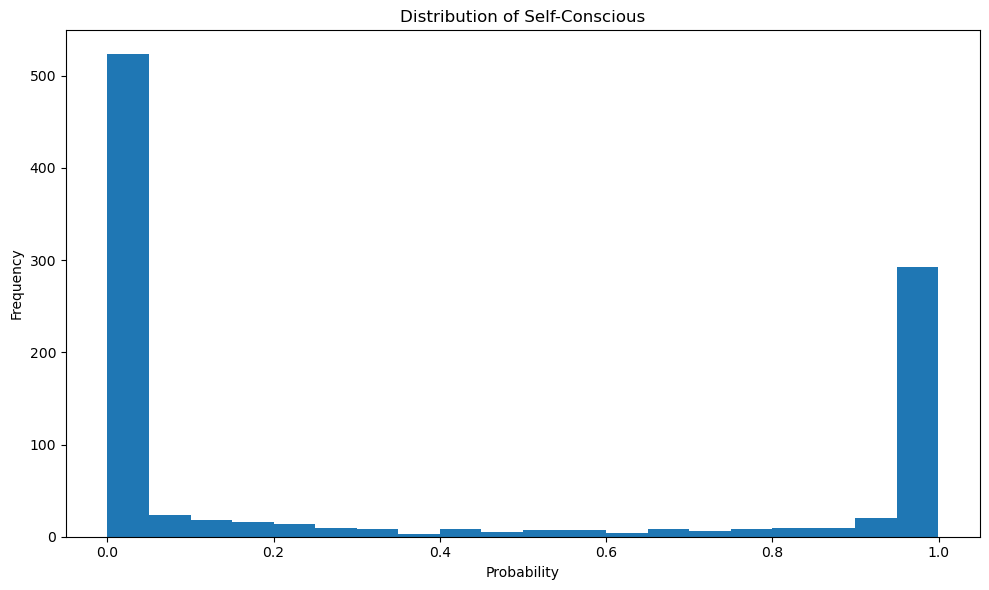

In [7]:
#histogram for individual emotions
import pandas as pd
import matplotlib.pyplot as plt

# Load the probabilities CSV file
file_path = '/Users/jaehyoyi/Desktop/인화원/MORAL_EMOTION/Moral-Emotion/predictions_probabilities.csv'  # Update this path to your local file
probabilities_df = pd.read_csv(file_path)

# Define the emotions
emotions = ['Non-Moral-Emotion', 'Neutral', 'Other-Suffering', 'Other-Praising', 'Other-Condemning', 'Self-Conscious']

# Create histograms for each emotion
for emotion in emotions:
    plt.figure(figsize=(10, 6))
    probabilities_df[emotion].hist(bins=20)
    plt.title(f'Distribution of {emotion}')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.tight_layout()
    
    # Save each histogram as an image
    plot_path = f'{emotion}_distribution.png'  # Update this path if needed
    plt.savefig(plot_path)

    # Display the plot
    plt.show()
